## CNN

In [38]:
import matplotlib.image as mpimg
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import os, sys, glob, re
from PIL import Image

import torch
import torch.nn as nn
from torch.nn.functional import *
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import *

import torchvision
import torchvision.transforms as T
from torchvision import models

import segmentation_models_pytorch as smp
from tqdm import tqdm

In [39]:
if torch.cuda.is_available():
    print("Name of the Graphics card", torch.cuda.get_device_name())
    print("Number of GPU available", torch.cuda.device_count())
    device = "cuda"
else:
    print("No GPU available on this machine")
    device = "cpu"

No GPU available on this machine


In [50]:
# Helper functions

def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

# Concatenate an image and its groundtruth
def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)          
        gt_img_3c[:,:,0] = gt_img8
        gt_img_3c[:,:,1] = gt_img8
        gt_img_3c[:,:,2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg

def img_crop(im, patch_size, padding):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    if is_2d:
        padding_channel = ((padding, padding), (padding, padding))
    else:
        padding_channel = ((padding, padding), (padding, padding), (0, 0))
    im = np.lib.pad(im, padding_channel, 'reflect')
    for i in range(padding, imgheight + padding, patch_size):
        for j in range(padding, imgwidth + padding, patch_size):
            if is_2d:
                im_patch = im[j - padding:j + patch_size + padding, i - padding:i + patch_size + padding]
            else:
                im_patch = im[j - padding:j + patch_size + padding, i - padding:i + patch_size + padding, :]
            list_patches.append(im_patch)
    return list_patches

def accuracy(predicted_logits, reference):
    """
    Compute the ratio of correctly predicted labels
    
    @param predicted_logits: float32 tensor of shape (batch size, num classes)
    @param reference: int64 tensor of shape (batch_size) with the class number
    """
    labels = torch.argmax(predicted_logits, 1)
    correct_predictions = labels.eq(reference)
    return correct_predictions.sum().float() / correct_predictions.nelement()

In [51]:
# Loaded a set of images
root_dir = "data/training/"
image_test = "data/test_set_images"
image_dir = root_dir + "images/"
files = os.listdir(image_dir)
#n = min(30, len(files))
n = len(files)
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]
print(files[0])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
print(files[0])

Loading 100 images
satImage_001.png
Loading 100 images
satImage_001.png


Image size = 400,400


Text(0.5, 1.0, 'real and groundtruth images')

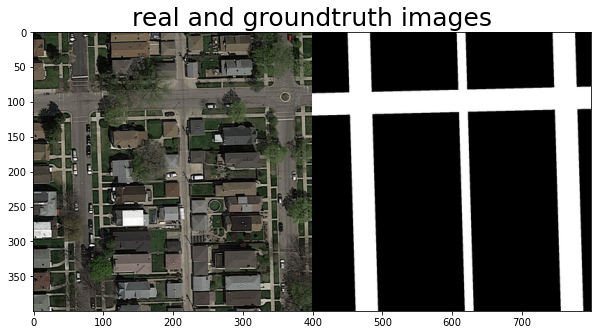

In [52]:
%matplotlib inline
i=5
print('Image size = ' + str(imgs[i].shape[0]) + ',' + str(imgs[i].shape[1]))

# Show first image and its groundtruth image
cimg = concatenate_images(imgs[i], gt_imgs[i])
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg, cmap='Greys_r')
plt.title("real and groundtruth images", fontdict={'fontsize':25})

In [53]:
# Extract patches from input images
patch_size = 16
window_size = 64
padding = (window_size - patch_size) // 2

img_patches = [img_crop(imgs[i], patch_size, padding) for i in range(n)]
gt_patches = [img_crop(gt_imgs[i], patch_size, 0) for i in range(n)]

# Linearize list of patches
img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])

# Mean and std of our dataset of image patches
mean_img = np.mean(img_patches, axis=(0, 1, 2))
std_img = np.std(img_patches, axis=(0, 1, 2))

In [54]:
# Extract 6-dimensional features consisting of average RGB color as well as variance
def extract_features(img):
    feat_m = np.mean(img, axis=(0,1))
    feat_v = np.var(img, axis=(0,1))
    feat = np.append(feat_m, feat_v)
    return feat

# Extract 2-dimensional features consisting of average gray color as well as variance
def extract_features_2d(img):
    feat_m = np.mean(img)
    feat_v = np.var(img)
    feat = np.append(feat_m, feat_v)
    return feat

# Extract features for a given image
def extract_img_features(filename):
    img = load_image(filename)
    img_patches = img_crop(img, patch_size, 0)
    X = np.asarray([ extract_features_2d(img_patches[i]) for i in range(len(img_patches))])
    return X 

#### Loading the training set

In [55]:
# Class describing the training dataset used by the CNN
class TrainsetCNN(Dataset):
    def __init__(self, x, y, augmentation=None):
        self.x = x
        self.y = torch.tensor(y).long()
        # Number of image patches in the dataset
        self.length = self.x.shape[0]
        # The way we normalize the image patches
        normalization = T.Normalize(mean_img, std_img)
        # The way we define data augmentation in our dataset
        if augmentation:
            self.augmentation = T.Compose([augmentation, normalization])
        else:
            self.augmentation = T.Compose([T.ToTensor(), normalization]) # No Data Augmentation

    def __getitem__(self, idx):
        return self.augmentation(self.x[idx]), self.y[idx]

    def __len__(self):
        return self.length



#### Training and Validation datasets

In [56]:
# Compute features for each image patch
foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

def value_to_class(v):
    df = np.sum(v)
    if df > foreground_threshold:
        return 1
    else:
        return 0

Y = np.asarray([value_to_class(np.mean(gt_patches[i])) for i in range(len(gt_patches))])

In [57]:
# the training set is imbalanced (too few roads)
def balanced_sampler (labels):
    # defining weights for the classes
    class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(labels), y = labels)
    print("Dealing with imbalanced datasets")
    print("Background weight: {:.3f}\nRoad weight: {:.3f}".format(class_weights[0], class_weights[1]))

    # Picking a road or a background patch with the same probability (=> balanced training set)
    weights = class_weights[labels]
    weights = torch.tensor(weights, dtype=torch.float32)
    sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))
    return sampler

In [58]:
# Trainset and Validation sets
img_train, img_valid, Y_train, Y_valid = train_test_split(img_patches, Y, test_size=0.2)

batch_size = 200
sampler = balanced_sampler(Y_train)
dataset_train = DataLoader(TrainsetCNN(img_train, Y_train), batch_size=batch_size, sampler=sampler)
dataset_valid = DataLoader(TrainsetCNN(img_valid, Y_valid), batch_size=batch_size, shuffle=True)

print("Number of patches in the training dataset: {}".format(len(img_train)))
print("Number of patches in the validation dataset: {}".format(len(img_valid)))

Dealing with imbalanced datasets
Background weight: 0.675
Road weight: 1.925
Number of patches in the training dataset: 50000
Number of patches in the validation dataset: 12500


#### Training the CNN

In [84]:
class LeNetModel(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3)
        self.batch_norm2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3)
        self.batch_norm3 = nn.BatchNorm2d(256)

        self.fc1 = nn.Linear(9216, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 2)


    def forward(self, x):
        # Convolutional Layers
        x = self.batch_norm1(leaky_relu(max_pool2d(self.conv1(x), 2)))
        x = dropout(x, 0.2, training=self.training)
        x = self.batch_norm2(leaky_relu(max_pool2d(self.conv2(x), 2)))
        x = dropout(x, 0.2, training=self.training)
        x = self.batch_norm3(leaky_relu(max_pool2d(self.conv3(x), 2)))
        x = dropout(x, 0.2, training=self.training)

        x = x.view(x.shape[0], -1)

        # Fully Connected Layers
        x = leaky_relu(self.fc1(x))
        x = dropout(x, 0.2, training=self.training)
        x = leaky_relu(self.fc2(x))
        x = dropout(x, 0.2, training=self.training)
        x = leaky_relu(self.fc3(x))
        x = dropout(x, 0.2, training=self.training)
        x = softmax(x, dim=1)

        return x

In [85]:
def train(model, criterion, dataset_train, dataset_valid, optimizer, scheduler, num_epochs):
    """
    @param model: torch.nn.Module
    @param criterion: torch.nn.modules.loss._Loss
    @param dataset_train: torch.utils.data.DataLoader
    @param dataset_valid: torch.utils.data.DataLoader
    @param optimizer: torch.optim.Optimizer
    @param num_epochs: int
    """
    print("Starting training")

    loss_train = []
    loss_valid = []

    for epoch in range(num_epochs):
        # Train an epoch
        model.train()
        running_loss = 0.
        for batch_x, batch_y in tqdm(dataset_train):
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            # Evaluate the network (forward pass)
            prediction = model(batch_x)
            loss = criterion(prediction, batch_y)
            running_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        loss_train.append(running_loss / len(dataset_train))


        # Test the quality on the validation set
        model.eval()
        accuracies_valid = []
        f1_valid = []
        running_loss = 0.
        for batch_x, batch_y in dataset_valid:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            prediction = model(batch_x)
            loss = criterion(prediction, batch_y)
            running_loss += loss.item()

            accuracies_valid.append(accuracy(prediction, batch_y))
            f1_valid.append(f1_score(batch_y.detach(), np.argmax(prediction.detach(), 1)))

        loss_valid.append(running_loss / len(dataset_valid))

        # Printing statistics
        accuracy_epoch = sum(accuracies_valid) / len(accuracies_valid)
        f1_epoch = sum(f1_valid) / len(f1_valid)
        print("Epoch {}".format(epoch + 1))
        print("val accuracy: {:.5f}, f1-score: {:.5f}\n".format(accuracy_epoch, f1_epoch))
        
        scheduler.step(f1_epoch)

    print("Finished")
    return loss_train, loss_valid

In [86]:
# hyperparameters
num_epochs = 80
learning_rate = 1e-3

# Criterion to optimize
criterion = torch.nn.CrossEntropyLoss()

In [87]:
## hyperparameters
#num_epochs = 10
#learning_rate = 1e-3

## Criterion to optimize
## the training set is imbalanced (too few roads) => defining weights for the classes
#class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(Y_train), y = Y_train)
#class_weights = torch.tensor(class_weights, dtype=torch.float32)
#criterion = torch.nn.CrossEntropyLoss(weight = class_weights)

#print("Dealing with imbalanced datasets")
#print("Background weight: {:.3f}\nRoad weight: {:.3f}".format(class_weights[0], class_weights[1]))

#### Performance of the Model without Data Augmentation

In [88]:
# plotting the loss curves for the train and the validation sets
def plot_performance (loss_train, loss_valid):
    epochs = range(1, num_epochs + 1)
    plt.plot(epochs, loss_train)
    plt.plot(epochs, loss_valid)
    plt.legend(["train loss", "validation loss"])
    plt.title('Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('loss')
    plt.show()

In [ ]:
# Training the CNN
model_lenet = LeNetModel().to(device)
optimizer = torch.optim.Adam(model_lenet.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, mode="max")
loss_train, loss_valid = train(model_lenet, criterion, dataset_train, dataset_valid, optimizer, scheduler, num_epochs)
plot_performance(loss_train, loss_valid)

  0%|                                                                                          | 0/250 [00:00<?, ?it/s]

Starting training


 53%|██████████████████████████████████████████▏                                     | 132/250 [05:57<05:30,  2.80s/it]

#### Performance of the Model with Data Augmentation

In [21]:
# Transformation of the original images (Data Augmentation)
augmentation = T.Compose([
    lambda x : np.around(x * 255).astype("uint8"),
    T.ToPILImage(),
    T.RandomVerticalFlip(0.5),
    T.RandomHorizontalFlip(0.5),
    T.RandomRotation(90),
    T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
    T.RandomAdjustSharpness(sharpness_factor=1.5),
    T.ToTensor(),
])

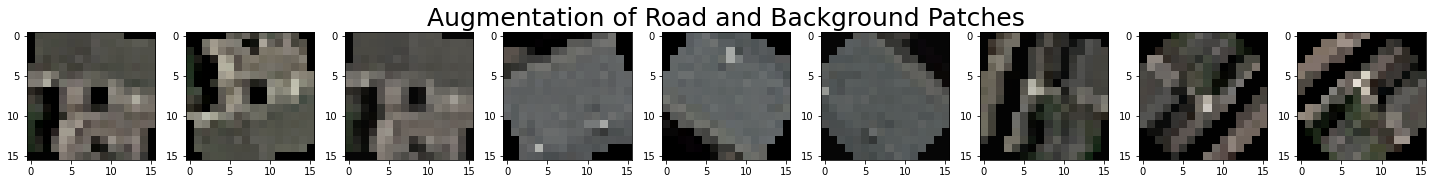

In [22]:
# Visualize possible augmentations for road and background patches from the Training dataset
ind_patches = [10, 5, 9]
fig, ax = plt.subplots(1, 3*len(ind_patches), figsize=(20, 20))
for i in range (3):
    for j in range (len(ind_patches)):
        ax[i + 3*j].imshow(augmentation(img_patches[ind_patches[j]]).permute(1, 2, 0).numpy())

ax[4].set_title("Augmentation of Road and Background Patches", fontdict={'fontsize':25})
plt.tight_layout()

In [23]:
# Augmented Training dataset and validation set
img_train, img_valid, Y_train, Y_valid = train_test_split(img_patches, Y, test_size=0.2)

batch_size = 200
sampler = balanced_sampler(Y_train)
trainsetAugmented = TrainsetCNN(img_train, Y_train, augmentation)
dataset_train = DataLoader(trainsetAugmented, batch_size=batch_size, sampler=sampler)

validset = TrainsetCNN(img_valid, Y_valid)
dataset_valid = DataLoader(validset, batch_size=batch_size, shuffle=True)

Dealing with imbalanced datasets
Background weight: 0.674
Road weight: 1.938


In [24]:
# Training the CNN on the Augmented Dataset
model_lenet = LeNetModel().to(device)
optimizer = torch.optim.Adam(model_lenet.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, mode="max")
loss_train, loss_valid = train(model_lenet, criterion, dataset_train, dataset_valid, optimizer, scheduler, num_epochs)
plot_performance(loss_train, loss_valid)

  0%|                                                                                          | 0/250 [00:00<?, ?it/s]

Starting training


  0%|                                                                                          | 0/250 [00:00<?, ?it/s]

Epoch 1
val accuracy: 0.73071, f1-score: 0.60039



  0%|                                                                                          | 0/250 [00:00<?, ?it/s]

Epoch 2
val accuracy: 0.77595, f1-score: 0.62888



  0%|                                                                                          | 0/250 [00:00<?, ?it/s]

Epoch 3
val accuracy: 0.72024, f1-score: 0.62387



  0%|                                                                                          | 0/250 [00:00<?, ?it/s]

Epoch 4
val accuracy: 0.78738, f1-score: 0.66527



 15%|████████████▎                                                                    | 38/250 [00:22<02:05,  1.69it/s]


KeyboardInterrupt: 

#### Testing the CNN on one image

Text(0.5, 1.0, 'Test Image 1')

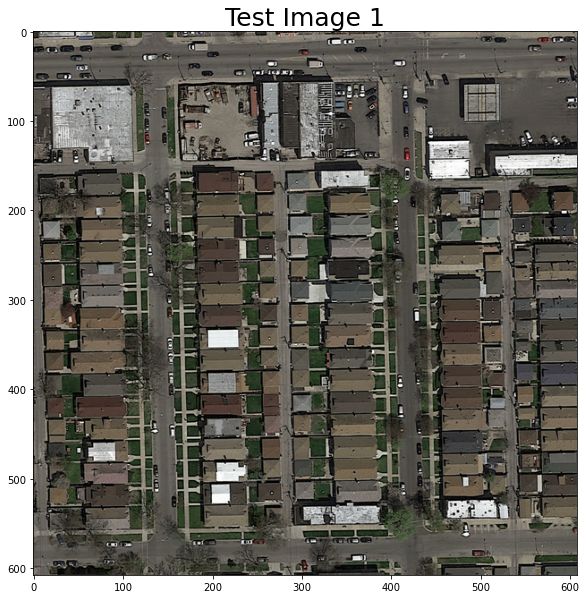

In [97]:
# Load all test images
test_images = list(glob.iglob(image_test + '/*/*.png', recursive=True))

# Extract one test image for visualization
test_1_path = test_images[0]
test_1 = load_image(test_1_path)

# show test image 1
plt.figure(figsize=(10, 10))
plt.imshow(test_1)
plt.title("Test Image 1", fontdict={'fontsize':25})

In [98]:
# Class describing the test dataset
class TestsetCNN(Dataset):
    def __init__(self, x, mean_train, std_train):        
        self.x = x
        self.transformation = T.Compose([T.ToTensor(), T.Normalize(mean_train, std_train)])
        self.length = len(self.x)

    def __getitem__(self, idx):
        return self.transformation(self.x[idx])
        
    def __len__(self):
        return self.length

In [99]:
def predict(model, dataset_test):
    """
    @param model: torch.nn.Module
    @param dataset_test: torch.utils.data.DataLoader
    """
    # Running the prediction for the test set
    model.eval()
    predicted_labels = []
    for batch_x in tqdm(dataset_test):
        predicted_logits = model(batch_x).detach().numpy()
        predicted_labels.append(np.argmax(predicted_logits, 1))
    return np.concatenate(predicted_labels)

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.43it/s]


True positive rate = 0.14889196675900276


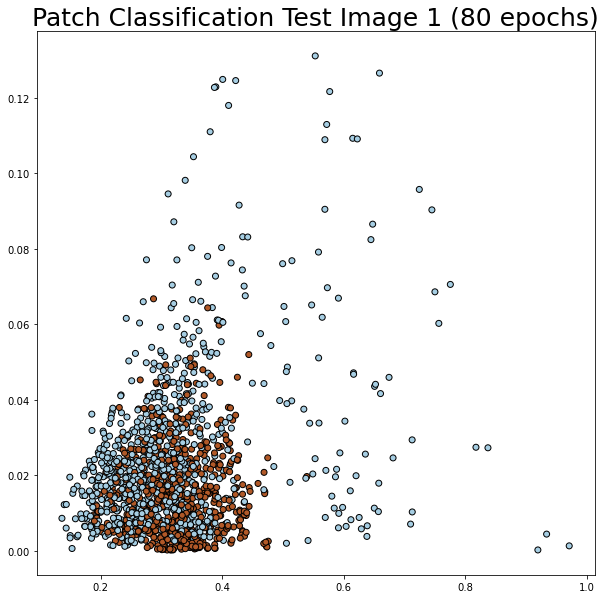

In [100]:
# Test set of image patches
patches_test = np.array(img_crop(test_1, patch_size, padding))
dataset_test = torch.utils.data.DataLoader(TestsetCNN(patches_test, mean_img, std_img), batch_size=batch_size, shuffle=False)

# Running the prediction for the test image
Zi = predict(model_lenet, dataset_test)

# Get non-zeros in prediction and grountruth arrays
Zn = np.nonzero(Zi)[0]
Yn = np.nonzero(Y)[0]
TPR = len(list(set(Yn) & set(Zn))) / float(len(Zi))
print('True positive rate = ' + str(TPR))

# Plot features using predictions to color datapoints
patches_test_2D = extract_img_features(test_1_path)
plt.figure(figsize=(10, 10))
plt.scatter(patches_test_2D[:, 0], patches_test_2D[:, 1], c=Zi, edgecolors='k', cmap=plt.cm.Paired)
plt.title("Patch Classification Test Image 1 ({} epochs)".format(num_epochs), fontdict={'fontsize':25})
plt.show()

In [101]:
# Convert array of labels to an image

def label_to_img(imgwidth, imgheight, w, h, labels):
    im = np.zeros([imgwidth, imgheight])
    idx = 0
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            im[j:j+w, i:i+h] = labels[idx]
            idx = idx + 1
    return im

def make_img_overlay(img, predicted_img):
    w = img.shape[0]
    h = img.shape[1]
    color_mask = np.zeros((w, h, 3), dtype=np.uint8)
    color_mask[:,:,0] = predicted_img*255

    img8 = img_float_to_uint8(img)
    background = Image.fromarray(img8, 'RGB').convert("RGBA")
    overlay = Image.fromarray(color_mask, 'RGB').convert("RGBA")
    new_img = Image.blend(background, overlay, 0.2)
    return new_img
    

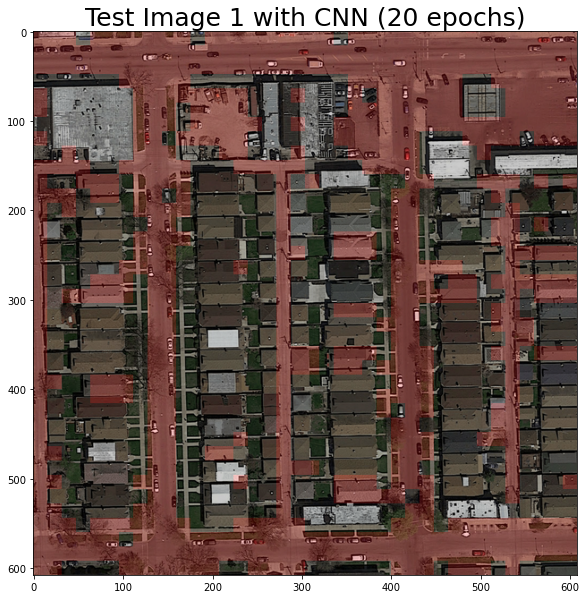

In [40]:
# Display prediction as an image

w = test_1.shape[0]
h = test_1.shape[1]
predicted_im = label_to_img(w, h, patch_size, patch_size, Zi)
cimg = concatenate_images(test_1, predicted_im)
plt.figure(figsize=(10, 10)) # create a figure with the default size 
plt.imshow(cimg, cmap='Greys_r')

new_img = make_img_overlay(test_1, predicted_im)

plt.title("Test Image 1 with CNN ({} epochs)".format(num_epochs), fontdict={'fontsize':25})
plt.imshow(new_img)

## Generating the predictions for the submission

In [31]:
# Building the augmented training set
batch_size = 200
sampler = balanced_sampler(Y)
trainsetAugmented = TrainsetCNN(img_patches, Y, augmentation)
dataset_train = DataLoader(trainsetAugmented, batch_size=batch_size, sampler=sampler)

Dealing with imbalanced datasets
Background weight: 0.657
Road weight: 2.088


In [32]:
def train_submissions (model, criterion, dataset_train, optimizer, num_epochs):
    print("Starting training")
    model.train()
    
    loss_train = []
    for epoch in range(num_epochs):
        # Train an epoch
        running_loss = 0.
        f1_train = []
        for batch_x, batch_y in tqdm(dataset_train):
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            # Evaluate the network (forward pass)
            prediction = model(batch_x)
            loss = criterion(prediction, batch_y)
            running_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            f1_train.append(f1_score(batch_y.detach(), np.argmax(prediction.detach(), 1)))

        loss_train.append(running_loss / len(dataset_train))
        f1_epoch = sum(f1_train) / len(f1_train)

        # Printing statistics
        print("Epoch {}".format(epoch + 1))
        print("train f1-score: {:.5f}\n".format(f1_epoch))

    print("Finished")
    return

In [33]:
# hyperparameters
num_epochs = 20
learning_rate = 1e-3

# Criterion to optimize
criterion = torch.nn.CrossEntropyLoss()

In [34]:
# Training the CNN
model_lenet = LeNetModel().to(device)
optimizer = torch.optim.Adam(model_lenet.parameters(), lr=learning_rate)
train_submissions(model_lenet, criterion, dataset_train, optimizer, num_epochs)

  0%|                                                                                           | 0/94 [00:00<?, ?it/s]

Starting training


  0%|                                                                                           | 0/94 [00:00<?, ?it/s]

Epoch 1
train f1-score: 0.60674



  0%|                                                                                           | 0/94 [00:00<?, ?it/s]

Epoch 2
train f1-score: 0.65955



  0%|                                                                                           | 0/94 [00:00<?, ?it/s]

Epoch 3
train f1-score: 0.69845



  0%|                                                                                           | 0/94 [00:00<?, ?it/s]

Epoch 4
train f1-score: 0.71595



  0%|                                                                                           | 0/94 [00:00<?, ?it/s]

Epoch 5
train f1-score: 0.72391



  0%|                                                                                           | 0/94 [00:00<?, ?it/s]

Epoch 6
train f1-score: 0.73371



  0%|                                                                                           | 0/94 [00:00<?, ?it/s]

Epoch 7
train f1-score: 0.73646



  0%|                                                                                           | 0/94 [00:00<?, ?it/s]

Epoch 8
train f1-score: 0.73731



  0%|                                                                                           | 0/94 [00:00<?, ?it/s]


KeyboardInterrupt: 

In [41]:
# Submissions
def mask_to_submission_strings(model, image_filename):
    """Reads a single image and outputs the strings that should go into the submission file"""
    model.eval()
    img_number = int(re.search(r"\d+", image_filename).group(0))
    im = np.asarray(mpimg.imread(image_filename))
    patch_size = 16
    for j in range(0, im.shape[1], patch_size):
        for i in range(0, im.shape[0], patch_size):
            patch = im[i:i + patch_size, j:j + patch_size, :]
            patch = T.Compose([T.ToTensor(), T.Normalize(mean_img, std_img)])(patch)
            predict = model(patch[np.newaxis, :])
            label = np.argmax(predict.detach().numpy(), 1)[0]
            yield("{:03d}_{}_{},{}".format(img_number, j, i, label))


def masks_to_submission(model, submission_filename, image_filenames):
    """Converts images into a submission file"""
    with open(submission_filename, 'w') as f:
        f.write('id,prediction\n')
        for fn in tqdm(image_filenames):
            f.writelines('{}\n'.format(s) for s in mask_to_submission_strings(model, fn))

test_files = list(glob.iglob(image_test + '/*/*.png', recursive=True))
masks_to_submission(model_lenet, "submission.csv", test_files)

 48%|███████████████████████████████████████▎                                          | 24/50 [01:56<02:06,  4.86s/it]


KeyboardInterrupt: 

## Comparing the Results using a Pretrained U-Net

#### Training dataset used by the ResNet 50

In [ ]:
# Class describing the training set used by the UNet
class TrainsetUNet(Dataset):
    def __init__(self, x, y, augmentation=None):
        self.x = x
        self.y = y
        self.length = len(self.x) # Number of image patches in the dataset
        # The way we define data augmentation in our dataset
        if augmentation:
            self.augmentation = augmentation
        else:
            self.augmentation = T.Compose([T.ToTensor()]) # No Data Augmentation

    def __getitem__(self, idx):
        return self.augmentation(self.x[idx]), self.augmentation(self.y[idx])

    def __len__(self):
        return self.length

In [ ]:
# Trainset and Validation sets
img_train, img_valid, gt_train, gt_valid = train_test_split(imgs, gt_imgs, test_size=0.5)

batch_size = 200
dataset_train = DataLoader(TrainsetUNet(img_train, gt_train), batch_size=batch_size, shuffle=True)
dataset_valid = DataLoader(TrainsetUNet(img_valid, gt_valid), batch_size=batch_size, shuffle=True)

print("Number of images in the training dataset: {}".format(len(img_train)))
print("Number of images in the validation dataset: {}".format(len(img_valid)))

#### Defining the Network U-Net to be used

In [ ]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid'

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=1, 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

#### Hyperparameters

In [ ]:
# Set flag to train the model or not. If set to 'False', only prediction is performed (using an older model checkpoint)
TRAINING = True

# Set num of epochs
EPOCHS = 5

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define loss function
loss = smp.utils.losses.DiceLoss()

# define metrics
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

# define optimizer
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.00008),
])

# define learning rate scheduler (not used in this NB)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)

# load best saved model checkpoint from previous commit (if present)
if os.path.exists('../input/unet-resnet50-frontend-road-segmentation-pytorch/best_model.pth'):
    model = torch.load('../input/unet-resnet50-frontend-road-segmentation-pytorch/best_model.pth', map_location=DEVICE)

In [ ]:
# Training the CNN on the Augmented Dataset
loss_train, loss_valid = train(model, loss, dataset_train, dataset_valid, optimizer, num_epochs)
plot_performance(loss_train, loss_valid)

In [ ]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [ ]:
%%time

if TRAINING:

    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(EPOCHS):

        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(dataset_train)
        valid_logs = valid_epoch.run(dataset_valid)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        # Save model if a better val IoU score is obtained
        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model, './best_model.pth')
            print('Model saved!')